# Safest district in Jharkhand :

## Introduction:

The whole world is fighting against the __CoVID-19__ pandemic, and in these tough times data analytics is playing a great role in better understanding the situation as to how to tackle it and is even promoting in finding a cure. 

So, I also thought of using the knowledge of data analytics that I have gained so far in making a project that focuses on the CoVID scenario of a state in __*India*__ in which I live i.e. '__JHARKHAND__'. 

This project aims to find out the __safest district__ to live among all the districts in the state, if you are in any case coming to __Jharkhand__, based on a variety of features and demographics.

## Data used:

there are various sources from which I gathered the required features. 
They include:
* __https://covidindia.org/jharkhand/__  *(for the no. of active case, deaths, total cases, etc...)*
* __https://www.nhm.gov.in/images/pdf/communitisation/rogi-kalyan-samiti/jharkhand_rks.pdf__  *(to get the no. of hospital manging societies in each district)*
* __geocoding from geocodefarm server.__  *(to get the latitude and longitude for each district)*

### - Importing libraries:

In [6]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import folium
import requests as req
import geocoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### - Using beautifulSoup library to web scrape the necessary data: 

In [147]:
data= req.get('https://covidindia.org/jharkhand/')
data= data.content
soup= BeautifulSoup(data)

In [148]:
dist= []
tot_cases= []
recov= []
deaths= []
active= []
lis= [dist,tot_cases,recov,deaths,active]

for i,val in enumerate(lis):
    for d in soup.find_all('td', attrs= {'class':'column-{}'.format(i+1)}):
        val.append(d.text)

lis[1]= lis[1][0:25]
lis[0]= lis[0][0:25]

for i in [0,1,2,3,4]:
    lis[i]= lis[i][:-1]

for i in range(0,5):
    print(len(lis[i]))

24
24
24
24
24


### - Creating a dataframe to tabulate all the scraped data:

In [151]:
columns= ['district','total_cases','recovered','deaths','active']
data= pd.DataFrame(columns= columns)

for i,val in enumerate(columns):
    try:
        data[val]= pd.to_numeric(lis[i]) #converting the text to numeric type
    except:
        data[val]= lis[i]

data.dtypes

district       object
total_cases     int64
recovered       int64
deaths          int64
active          int64
dtype: object

In [152]:
data['no_of_hospital_managing_societies']= [27,8,14,44,32,16,10,28,1,16,2,10,0,7,13,15,7,24,0,49,5,16,16,16] #the no. of hospital managing societies in each district

### - Using the geocoding API to retrieve the co-ordinates of each district and tabulating it:

In [171]:
lat= []
lng= []

for district in data.district:
    latlng= geocoder.geocodefarm('{},jharkhand,India'.format(district)).latlng
    lat.append(latlng[0])
    lng.append(latlng[1])
    
data['lat']= lat
data['lng']= lng

In [170]:
data['death_per_recovery']= (data['deaths']/data['recovered'])*100 #calculates the no. of deaths for each recovery

for i in range(0,len(data)):
    data.loc[i,'recovered']= int((data.loc[i,'recovered']/data.loc[i,'total_cases'])*100) #recovered %
    data.loc[i,'deaths']= int((data.loc[i,'deaths']/data.loc[i,'total_cases'])*100) #death %
    data.loc[i,'active']= int((data.loc[i,'active']/data.loc[i,'total_cases'])*100) #active cases %
    data.loc[i,'total_cases']= int((data.loc[i,'total_cases']/data.total_cases.sum())*100) #cases in ech district relative to total cases %  
    data.loc[i,'no_of_hospital_managing_societies']= (data.loc[i,'no_of_hospital_managing_societies']/data.loc[i,'active'])*100 #no. of hospital management societies per active patient

In [156]:
# renaming some columns
for i,val in enumerate(data.columns[1:6].values):
    if i==4:
        data.rename(columns={val:val+'_per_active_cases'},inplace= True)
    elif i==0:
        data.rename(columns={val:val+'_%of_total_cases_in_jharkhand'},inplace= True)
    else:
        data.rename(columns={val:val+'_%of_total_cases_per_district'},inplace= True)

In [2]:
data= pd.read_csv('covid_jharkhand.csv') #reading the backup final csv file
data.drop(['Unnamed: 0'],axis= 1,inplace= True)

In [3]:
data.shape

(24, 9)

In [4]:
data.head()

,district,total_cases_%of_total_cases_in_jharkhand,recovered_%of_total_cases_per_district,deaths_%of_total_cases_per_district,active_%of_total_cases_per_district,no_of_hospital_managing_societies_per_active_cases,death_per_recovery,lat,lng
0,Bokaro,1,55,1,43,62.790698,1.818182,23.779985,85.969322
1,Chatra,3,60,0,39,20.512821,0.000000,24.206200,84.871300
2,Deoghar,1,49,0,50,28.000000,0.000000,24.491533,86.691254
3,Dhanbad,6,38,2,59,74.576271,5.263158,23.794043,86.426170
4,Dumka,0,69,0,30,106.666667,0.000000,24.265244,87.250191


### - Plotting for Exploratory Data Analysis: 

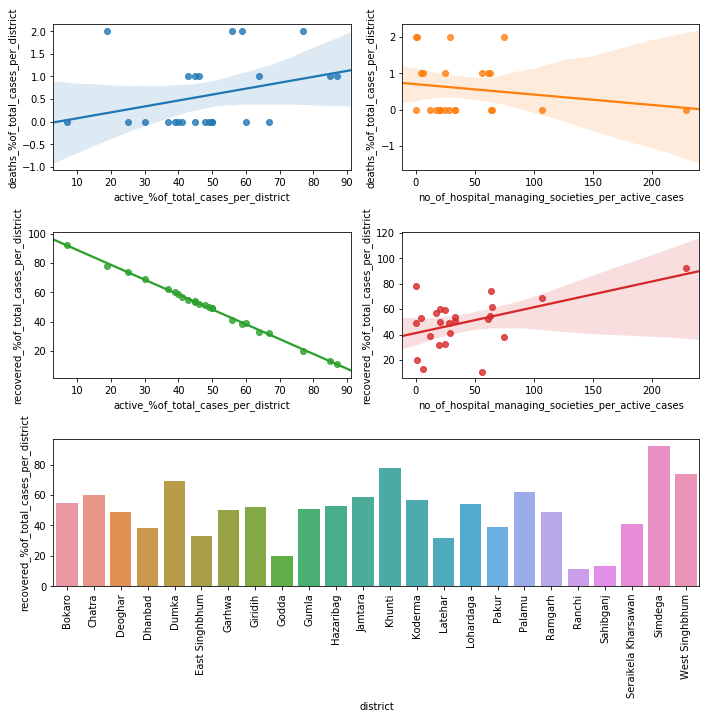

In [92]:
fig= plt.figure(figsize= (10,10))

ax1= fig.add_subplot(3,2,1)
ax2= fig.add_subplot(3,2,2)
ax3= fig.add_subplot(3,2,3)
ax4= fig.add_subplot(3,2,4)
ax5= fig.add_subplot(3,1,3)

sns.regplot('active_%of_total_cases_per_district','deaths_%of_total_cases_per_district', data= data, ax= ax1)
sns.regplot('no_of_hospital_managing_societies_per_active_cases','deaths_%of_total_cases_per_district', data= data, ax= ax2)
sns.regplot('active_%of_total_cases_per_district','recovered_%of_total_cases_per_district', data= data, ax= ax3)
sns.regplot('no_of_hospital_managing_societies_per_active_cases','recovered_%of_total_cases_per_district', data= data, ax= ax4)
sns.barplot(x= data['district'],y= data['recovered_%of_total_cases_per_district'],ax= ax5)

plt.xticks(rotation= 90)

plt.tight_layout()


your credentials are __here__
<!--
CLIENT_ID = 'VOSZ5IO22Y2MTUL5V5F55VWJW1GQSBKXVC5OQDN2C0LR0PUF' # your Foursquare ID
CLIENT_SECRET = '2FB3FOFPLQQKRAVLZMGV5FPM2BIRVSO2GGZ3V2O5T4QNET3R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
-->

### - Using the Foursquare API to count the nearby commercial places available:
*note: the server is down for several days in my region hence couldn't add its data so please grade accordingly*

In [217]:
dat= []
num= []
for name,lat,lng in zip(data.district,data.lat,data.lng):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
    
    res= req.get(url).json()
    
    dat.append([(name,lat,lng,i['venue']['name'],i['venue']['categories'][0]['name'],i['venue']['location']['lat'],i['venue']['location']['lng']) for i in res['response']['groups'][0]['items']])
    num.append(len(dat))  #no. of commercial places available nearby

ConnectionError: HTTPSConnectionPool(host='api.foursquare.com', port=443): Max retries exceeded with url: /v2/venues/explore?&client_id=VOSZ5IO22Y2MTUL5V5F55VWJW1GQSBKXVC5OQDN2C0LR0PUF&client_secret=2FB3FOFPLQQKRAVLZMGV5FPM2BIRVSO2GGZ3V2O5T4QNET3R&v=20180605&ll=23.7799854278389,85.9693222041408&radius=500&limit=100 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x0000026996B92508>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

### - Visualising the districts using folium:

In [176]:
jhar= folium.Map(location= [23.6102, 85.2799],zoom_start= 7, tiles= 'Stamen Terrain')

for lat,lng,dist,rec,death,act in zip(data.lat, data.lng, data.district, data['recovered_%of_total_cases_per_district'], data['deaths_%of_total_cases_per_district'], data['active_%of_total_cases_per_district'] ):
    
    folium.Marker([lat,lng], popup= 'recovered%={} death%={} active%={}'.format(rec,death,act), tooltip= dist).add_to(jhar)

jhar

### - Model development:

In [93]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [94]:
x_train= StandardScaler().fit_transform(data.iloc[:,1:7])

Text(0, 0.5, 'inertia')

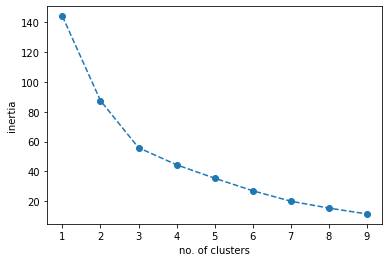

In [95]:
iner= []

for i in range(1,10):
    km= KMeans(n_clusters= i).fit(x_train)
    iner.append(km.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([i for i in range(1,10)],iner,'o--') # plotting the intertias to get the elbow point (in this case 3)
plt.xlabel('no. of clusters')
plt.ylabel('inertia')

In [235]:
km= KMeans(n_clusters= 3).fit(x_train)
labels= km.labels_

In [236]:
x= data.iloc[:,1:7]

x['labels']= labels

x.groupby(['labels']).mean()

,total_cases_%of_total_cases_in_jharkhand,recovered_%of_total_cases_per_district,deaths_%of_total_cases_per_district,active_%of_total_cases_per_district,no_of_hospital_managing_societies_per_active_cases,death_per_recovery
labels,,,,,,
0,46.500,83.0000,0.0000,16.000000,146.285714,0.000000
1,19.500,26.0000,1.5000,71.333333,31.941766,6.659121
2,4.875,54.3125,0.3125,44.312500,31.772919,0.512010


we can infer the clusters to be indicative of:
* __high recovery and low death/recovery__ (cluster 0) (safest)
* __low recovery, high death% and death/recovery__ (cluster 1) (most unsafe)
* __low total_case% and low death% but low hospital_societies/case and also greater active%_per_district__ (cluster 2) (considerable)

### - Plotting the color coded districts according to their cluster label:

In [207]:
data['labels']= labels

In [210]:
col= ['green','red','orange'] #green: safest
                              #red: most unsafe
                              #orange: considerable

jhar= folium.Map(location= [23.6102, 85.2799],zoom_start= 7, tiles= 'Stamen Terrain')

for lat,lng,label,dist,rec,death,act in zip(data.lat, data.lng, data.labels, data.district, data['recovered_%of_total_cases_per_district'], data['deaths_%of_total_cases_per_district'], data['active_%of_total_cases_per_district'] ):
    
    folium.Marker([lat,lng], icon= folium.Icon(color= col[label]),popup= 'recovered%={} death%={} active%={}'.format(rec,death,act), tooltip= dist).add_to(jhar)

jhar

#### I hope you guys enjoyed going through the notebook !! 